# Titanic challenge: simple logistic regression model 
This notebook shows how to solve the Titanic challenge with a simple logistic regression model. The notebook is divided in three parts:
- Data exploration
- Feature engineering
- Classification: logistic regression

The goal is to predict the survival or the death of a given passenger based on a set of available variables. Having more features (in this case, using more variables) is not always advantageous, quite the opposite! Especially in logistic regression, we aim at the simpler model that can explain the data. 

In [1]:
# import libraries
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sklearn

In [2]:
# load data
train_data = pd.read_csv('../input/titanic/train.csv')

test_data = pd.read_csv('../input/titanic/test.csv')

## Data exploration

In [3]:
print(train_data.shape) 

(891, 12)


The training data consists of 891 observations of 12 variables.

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The Survived column is the target variable, taking value of 1 if the passenger survived, 0 if the passenger died.

The other variables (possible predictors) are:

- PassengerId: id of the passenger
- Pclass: the passenger's class, which has possible values 1,2,3 (first, second and third class)
- Name of the passenger
- Sex
- Age
- SibSp: number of siblings and spouse traveling with the passenger 
- Parch: number of parents and children traveling with the passenger
- Ticket number
- Ticket Fare
- Cabin number 
- Embarkation: Port of Embarkation, one of C (Cherbourg), Q (Queenstown), S (Southampton)

### Explore variables

#### Missing values

In [5]:
# Find missing values
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

A large number of values is missing for the variables Cabin (77%) and Age (20 %). Only 2 values are missing for the variable Embarked. We will drop the variable Cabin since the proportion of missing values is too large, whereas we will fill in the missing variables for Age and Embarked. 

In [6]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

There are many missing values for the variables Cabin and Age also in the test data, plus one missing value for the Fare variable. 

#### Summary statistics

In [7]:
# Visualize the first rows of the table
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# compute and display summary statistics
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Based on this data we can say:
- 38% of the passengers survived
- the oldest person was 80 years old and the yougest person was less than one year old
- More than 50% of people did not come with any siblings or spouses
- The highest fare was 512.3 and the lowest was 0

### Model based only on gender 

How the 38 %  passenger who survived are distributed among male and females?

In [9]:
print(sum(train_data.Survived)) # 342 out of 891 passenger survived

342


<AxesSubplot:xlabel='Survived', ylabel='count'>

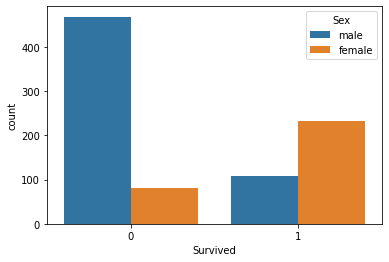

In [10]:
sns.countplot(x='Survived', hue='Sex', data=train_data)

In [11]:
women = train_data.loc[train_data.Sex == 'female']['Survived']
women_survived = sum(women)
tot_women = len(women)
rate_women = women_survived/tot_women * 100
print(women_survived,'women survived of the',tot_women,'women on board','({:.2f}'.format(rate_women),'%)')

233 women survived of the 314 women on board (74.20 %)


In [12]:
men = train_data.loc[train_data.Sex == 'male']['Survived']
men_survived = sum(men)
tot_men = len(men)
rate_men = men_survived/tot_men * 100
print(men_survived,'men survived of the',tot_men,'men on board','({:.2f}'.format(rate_men),'%)')

109 men survived of the 577 men on board (18.89 %)


The Sex of the passenger is an important predictor: 74.20 % of the women onboard survived with respect of only 18.89 % of the men. Therefore a very simple model that predicts the survival on the basis of the variable Sex only (if passenger is female predict survival, otherwise death) would have an accuracy of about 74.20 %.

### Looking deeper into differences between females and males statistics

In [13]:
train_data.groupby(['Sex','Pclass']).mean()

PassengerId  Survived        Age     SibSp     Parch  \
Sex    Pclass                                                         
female 1        469.212766  0.968085  34.611765  0.553191  0.457447   
       2        443.105263  0.921053  28.722973  0.486842  0.605263   
       3        399.729167  0.500000  21.750000  0.895833  0.798611   
male   1        455.729508  0.368852  41.281386  0.311475  0.278689   
       2        447.962963  0.157407  30.740707  0.342593  0.222222   
       3        455.515850  0.135447  26.507589  0.498559  0.224784   

                     Fare  
Sex    Pclass              
female 1       106.125798  
       2        21.970121  
       3        16.118810  
male   1        67.226127  
       2        19.741782  
       3        12.661633

Grouping passengers based on Sex and Ticket class (Pclass) we can notice other difference between survival rates:
- Women in the first and second class are highly likely to survive, while women in the third class have 50 % chance of survival.
- Men in the first class are almost 3-times more likely to survive than men in the third class.

We can confirm this information also with barplots. Note that by default, the barplot() function draws error bars in the plot with 95% confidence interval.

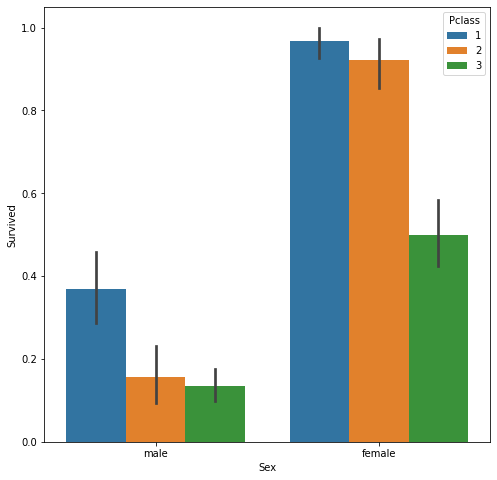

In [14]:
plt.figure(figsize=(8,8))
sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data = train_data)
plt.show()

### Children
Now we will look at how the age of the passenger affected their chance of survival.

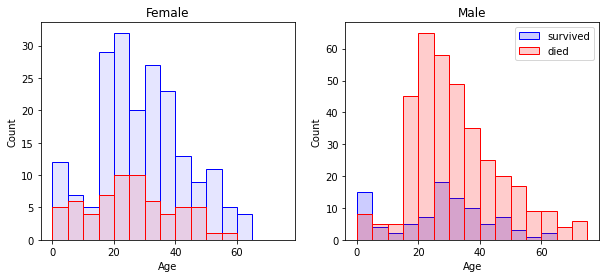

In [15]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10, 4))
women = train_data[train_data['Sex']=='female']
men = train_data[train_data['Sex']=='male']

ax = sns.histplot(women[women['Survived']==1].Age.dropna(), ax=axes[0], bins=range(0, 80, 5), label = 'survived', color='blue', edgecolor='blue', alpha=0.1)
ax = sns.histplot(women[women['Survived']==0].Age.dropna(), ax=axes[0], bins=range(0, 80, 5), label = 'died', color='red', edgecolor='red', alpha=0.1)

ax.set_title('Female')

ax = sns.histplot(men[men['Survived']==1].Age.dropna(), ax=axes[1], bins=range(0, 80, 5), label = 'survived',  color='blue', edgecolor='blue', alpha=0.2)
ax = sns.histplot(men[men['Survived']==0].Age.dropna(), ax=axes[1], bins=range(0, 80, 5), label = 'died', color='red', edgecolor='red', alpha=0.2)
ax.legend()
_ = ax.set_title('Male')

In [16]:
train_data[train_data['Age']<18].groupby(['Sex','Pclass']).mean()

PassengerId  Survived        Age     SibSp     Parch  \
Sex    Pclass                                                         
female 1        525.375000  0.875000  14.125000  0.500000  0.875000   
       2        369.250000  1.000000   8.333333  0.583333  1.083333   
       3        374.942857  0.542857   8.428571  1.571429  1.057143   
male   1        526.500000  1.000000   8.230000  0.500000  2.000000   
       2        527.818182  0.818182   4.757273  0.727273  1.000000   
       3        437.953488  0.232558   9.963256  2.069767  1.000000   

                     Fare  
Sex    Pclass              
female 1       104.083337  
       2        26.241667  
       3        18.727977  
male   1       116.072900  
       2        25.659473  
       3        22.752523

Children have a higher chance of survival, especially in the first and second class. This confirms the known fact that, during the slow sinking of the Titanic, the crew enforced the order of saving women and children first. 

### Port of embarkation

We have seen that sex, class of the passenger and age are variables affecting the survival chance of a passenger. Now we'll look at the effect of the port of embarkation. 

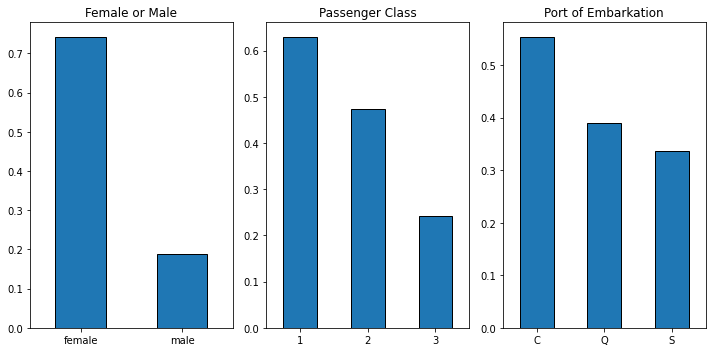

In [17]:
fig1, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
train_data.groupby('Sex')['Survived'].mean().plot.bar(ax=ax1[0], rot=0, title='Female or Male', edgecolor="k", xlabel='')
train_data.groupby('Pclass')['Survived'].mean().plot.bar(ax=ax1[1], rot=0, title='Passenger Class', edgecolor="k", xlabel='')
train_data.groupby('Embarked')['Survived'].mean().plot.bar(ax=ax1[2], rot=0, title='Port of Embarkation', edgecolor="k", xlabel='')

plt.tight_layout()
plt.show()

It seems that passenger embarked in Cherbourg have higher chance of survival then those embarked in Queenstown and Southampton. Let's look at the sex and class of the passenger embarked in each port. 

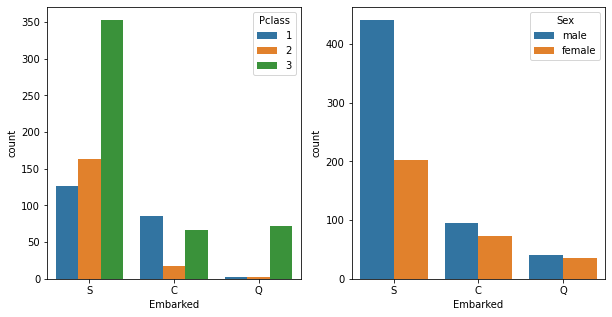

In [18]:
fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = sns.countplot(x='Embarked', hue='Pclass', data=train_data, ax=ax2[0])
ax = sns.countplot(x='Embarked', hue='Sex', data=train_data, ax=ax2[1])

Interestingly, we notice that:
- the proportion of first class passengers embarked in Cherbourg is much higher with respect to the other two ports
- A higher proportion of females has embarked both in Chenbourg and Queenstown than in Southampton. 

Since sex and class are the reasons behind the highest survival rate of passengers embarked in Chenbourg and Queenstown with respect to those embarked in Southampton, including the variable Embarked in our model would cause redundancy. Why would the port of embarkation make any difference? 

### Fare

Let's explore the relationship between the ticket price paid by a passenger (Fare) and their chance of survival. Does the variable Fare provide additional information than only Pclass?

In [19]:
train_data[["Fare"]].describe()

,Fare
count,891.000000
mean,32.204208
std,49.693429
min,0.000000
25%,7.910400
50%,14.454200
75%,31.000000
max,512.329200


The Fare value can range between 0 and 512. Let's see the mean and median values grouped by class and sex.

In [20]:
print('Mean:\n',train_data.groupby(['Sex', 'Pclass'])['Fare'].mean(),'\n')
print('Median:\n',train_data.groupby(['Sex', 'Pclass'])['Fare'].median())

Mean:
 Sex     Pclass
female  1         106.125798
        2          21.970121
        3          16.118810
male    1          67.226127
        2          19.741782
        3          12.661633
Name: Fare, dtype: float64 

Median:
 Sex     Pclass
female  1         82.66455
        2         22.00000
        3         12.47500
male    1         41.26250
        2         13.00000
        3          7.92500
Name: Fare, dtype: float64


The comparison of mean and median values shows that there are certainly some outliers. 

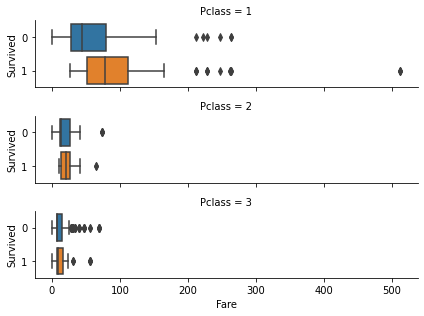

In [21]:
sns.catplot(x='Fare', y='Survived', row='Pclass', kind='box',
            orient='h', height=1.5, aspect=4, data=train_data)

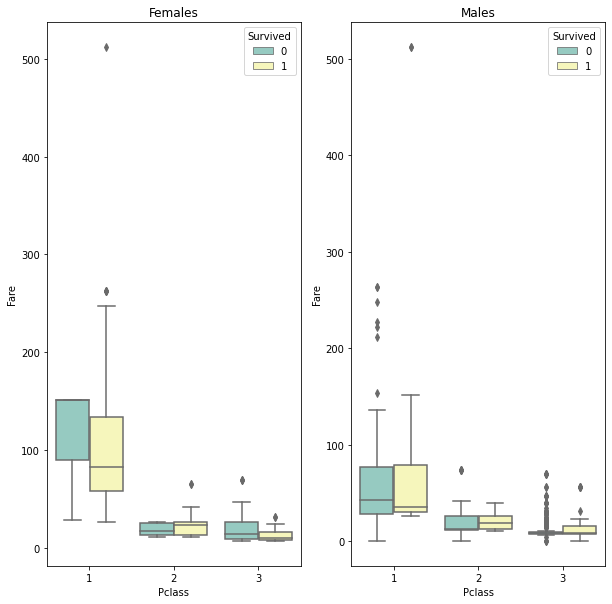

<Figure size 576x576 with 0 Axes>

In [22]:
women = train_data[(train_data['Sex'] == 'female')]
men = train_data[(train_data['Sex'] == 'male')]

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10, 10))
plt.figure(figsize=(8,8))
ax = sns.boxplot(data=women, x="Pclass", y="Fare", hue="Survived", palette="Set3", ax=axes[0]).set_title('Females')

ax = sns.boxplot(data=men, x="Pclass", y="Fare", hue="Survived", palette="Set3", ax=axes[1]).set_title('Males')

At first it seems that the variable Fare may add additional information: both first and second class passengers who survived are likely to have paid a higher Fare than the other passengers of the same class. However, in each class females paid a higher fee than males, so it is likely that difference chance of survival related to the paid fare is due to the sex of the passenger. 

## Feature engineering

Having more features is not always advantageous, quite the opposite! Redundant and correlated features affects negatively the performance of the model. For example the variable "Fare" is highly correlated with the class and gender of the passenger, and has therefore a prective power, but it becomes redundant in a model already cointaing "class" and "sex". Especially in logistic regression, we aim at the simpler model that can explain the data. Therefore here we will limit our predictors to the following most informative variables:

- sex
- age
- class
- family size

We will create categorical variables to better represent these factors.

In [23]:
# Extract and then remove the targets from the training data 
targets = train_data.Survived
train_data.drop(['Survived'], axis=1, inplace=True)

# Merge train and test data for feature engineering
combined = train_data.append(test_data) 
combined.reset_index(inplace=True)

# Remove non informative features
combined.drop(['index','PassengerId','Name','Ticket','Cabin','Fare','Embarked'], axis=1, inplace=True) 

In [24]:
print(combined.shape)

(1309, 5)


In [25]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,male,22.0,1,0
1,1,female,38.0,1,0
2,3,female,26.0,0,0
3,1,female,35.0,1,0
4,3,male,35.0,0,0


### Age variable
The Age variable is missing a large number of values. Simply replacing them with the mean or the median age is not the best solution since the age differs by categories of passengers. 
Therefore, we will fill in the missing values on the base of both Sex and Class of the passenger.

To avoid data leakage from the test set, we fill in missing ages in the train using the train set and we fill in ages in the test set using values calculated from the train set as well.

In [26]:
print(combined.iloc[:891].Age.isnull().sum()) # Number of missing ages in train set

177


In [27]:
print(combined.iloc[891:].Age.isnull().sum()) # Number of missing ages in test set

86


In [28]:
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Age']]

In [29]:
grouped_median_train.head()

,Sex,Pclass,Age
0,female,1,35.0
1,female,2,28.0
2,female,3,21.5
3,male,1,40.0
4,male,2,30.0


First we create a function that fills in the missing age based on Sex and Class.

In [30]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global combined
    # a function that fills the missing values of the Age variable
    combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return combined

In [31]:
combined = process_age()
combined.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,male,22.0,1,0
1,1,female,38.0,1,0
2,3,female,26.0,0,0
3,1,female,35.0,1,0
4,3,male,35.0,0,0


For modeling the effect that age has on the chance of survival of a passenger, we introduce a categorical variable "AgeGroup" with levels Child (0-12 y.o.), Teenager (13-19 y.o.), Adult(>= 20 y.o.)

In [32]:
def process_age_group():
    
    global combined
    combined['Child'] = combined['Age'].map(lambda s: 1 if s <= 12 else 0)
    combined['Teenager'] = combined['Age'].map(lambda s: 1 if 13 <= s <= 19 else 0)
    combined['Adult'] = combined['Age'].map(lambda s: 1 if s >= 20 else 0)
    
    # removing "Age"
    combined.drop('Age',axis=1,inplace=True)
    
    return combined

In [33]:
combined = process_age_group()
combined.head()

,Pclass,Sex,SibSp,Parch,Child,Teenager,Adult
0,3,male,1,0,0,0,1
1,1,female,1,0,0,0,1
2,3,female,0,0,0,0,1
3,1,female,1,0,0,0,1
4,3,male,0,0,0,0,1


### Sex variable
This function maps the string values male and female to 1 and 0 respectively.

In [34]:
def process_sex():
    global combined
    # mapping string values to numerical one 
    combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
    
    return combined

In [35]:
combined = process_sex()
combined.head()

,Pclass,Sex,SibSp,Parch,Child,Teenager,Adult
0,3,1,1,0,0,0,1
1,1,0,1,0,0,0,1
2,3,0,0,0,0,0,1
3,1,0,1,0,0,0,1
4,3,1,0,0,0,0,1


### PClass variable
This function encodes the values of Pclass (1,2,3) using a dummy encoding.

In [36]:
def process_pclass():
    
    global combined
    # encoding into 3 categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix='Pclass')
    
    # adding dummy variable
    combined = pd.concat([combined, pclass_dummies],axis=1)
    
    # removing "Pclass"
    combined.drop('Pclass',axis=1,inplace=True)
    
    return combined

In [37]:
combined = process_pclass()
combined.head()

,Sex,SibSp,Parch,Child,Teenager,Adult,Pclass_1,Pclass_2,Pclass_3
0,1,1,0,0,0,1,0,0,1
1,0,1,0,0,0,1,1,0,0
2,0,0,0,0,0,1,0,0,1
3,0,1,0,0,0,1,1,0,0
4,1,0,0,0,0,1,0,0,1


### Family variable

In [38]:
def process_family():
    
    global combined
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # introducing other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    # removing Parch and SibSp
    combined.drop('Parch',axis=1,inplace=True)
    combined.drop('SibSp',axis=1,inplace=True)
    combined.drop('FamilySize',axis=1,inplace=True)
    
    return combined

This function introduces 4 new features:
- FamilySize : the total number of relatives including the passenger (him/her)self.
- Sigleton : a boolean variable that describes families of size = 1
- SmallFamily : a boolean variable that describes families of 2 <= size <= 4
- LargeFamily : a boolean variable that describes families of size > 5

In [39]:
combined = process_family()
combined.head()

,Sex,Child,Teenager,Adult,Pclass_1,Pclass_2,Pclass_3,Singleton,SmallFamily,LargeFamily
0,1,0,0,1,0,0,1,0,1,0
1,0,0,0,1,1,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0
3,0,0,0,1,1,0,0,0,1,0
4,1,0,0,1,0,0,1,1,0,0


## Classification: logistic regression

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('../input/titanic/train.csv', usecols=['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets

train, test, targets = recover_train_test_target()

In [42]:
clf = LogisticRegression(solver='liblinear')
clf = clf.fit(train, targets)

In [45]:
output = clf.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('../input/titanic/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('submission.csv', index=False)

In [46]:
print(df_output)

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


Now the predictions contained in the file logReg.csv can be submitted to the competition!